# Technical test results for HEVA company

This notebook repeats the statement of the test. Under each activity you will find the code and the result produced.
You will find all the requirements to run this notebook in the requirements.md file.

## Configuration

### 1. Importing packages

In [33]:
# Import necessary modules

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when

### 2. Settings

In [7]:
# Definition of necessary parameters
data_path = "../sources/data/movies.sqlite"

### 3. Reading data

In [9]:
def read_data(data_path):
    """ Configuring the Pyspark session with the jdbc package
        to read the "movies.sqlite" file.

    Args:
        data_path (string): The sqlite data file path

    Returns:
        tuple: A tuple of 2 Pyspark Dataframes
    """

    # Creation of the Spark session
    spark = SparkSession.builder\
        .config(
            'spark.jars.packages',
            'org.xerial:sqlite-jdbc:3.34.0')\
        .getOrCreate()

    # Reading the movies table
    df_movies = spark.read.format('jdbc')\
        .options(
            driver='org.sqlite.JDBC',
            dbtable='movies',
            url=f'jdbc:sqlite:{data_path}')\
        .load()

    # Reading the ratings table
    df_ratings = spark.read.format('jdbc')\
        .options(
            driver='org.sqlite.JDBC',
            dbtable='ratings',
            url=f'jdbc:sqlite:{data_path}')\
        .load()

    return df_movies, df_ratings


df_movies, df_ratings = read_data(data_path)

### 4. Data overview

In [11]:
def preview_data(df_movies, df_ratings):
    """Showing top 20 rows

    Args:
        df_movies (Dataframe): Movies Dataframe
        df_ratings (Dataframe): Ratings Dataframe
    """

    # Overview of movies table data
    print("Movies table")
    df_movies.show()

    # Preview data from the ratings table
    print("Ratings table")
    df_ratings.show()


preview_data(df_movies, df_ratings)

Movies table
+--------+--------------------+--------------------+
|movie_id|               title|               genre|
+--------+--------------------+--------------------+
|       8|Edison Kinetoscop...|   Documentary|Short|
|      10|La sortie des usi...|   Documentary|Short|
|      12|The Arrival of a ...|   Documentary|Short|
|      25|The Oxford and Ca...|                null|
|      91|Le manoir du diab...|        Short|Horror|
|     131|Une nuit terrible...| Short|Comedy|Horror|
|     417|A Trip to the Moo...|Short|Action|Adve...|
|     439|The Great Train R...|Short|Action|Crim...|
|     443|Hiawatha, the Mes...|                null|
|     628|The Adventures of...|        Action|Short|
|     833|The Country Docto...|         Short|Drama|
|    1223| Frankenstein (1910)| Short|Horror|Sci-Fi|
|    1740|The Lonedale Oper...| Short|Drama|Romance|
|    2101|    Cleopatra (1912)|       Drama|History|
|    2130|    L'inferno (1911)|Adventure|Drama|F...|
|    2354|Max et Jane veule...|Sh

## Tasks

### 1. Counts

- 1.1 How many films are in the database?

In [13]:
def activity_1_1(df_movies):
    """Counting the number of distinct film titles

    Args:
        df_movies (Dataframe): Movies Dataframe

    Return:
        int: Number of movies
    """

    return df_movies\
        .select("title")\
        .distinct()\
        .count()


result_1_1 = activity_1_1(df_movies)
print("There are", result_1_1, "movies in the database")

There are 37947 movies in the database


- 1.2 How many different users are in the database?

In [15]:
def activity_1_2(df_ratings):
    """Counting the number of distinct user id

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    Return:
        int: Number of user id
    """

    return df_ratings\
        .select("user_id")\
        .distinct()\
        .count()


result_1_2 = activity_1_2(df_ratings)
print("There are", result_1_2, "user id in the database")

There are 71707 user id in the database


- 1.3 What is the distribution of the notes provided?
     **Bonus**: create a histogram.

Converting Dataframe to Pandas...


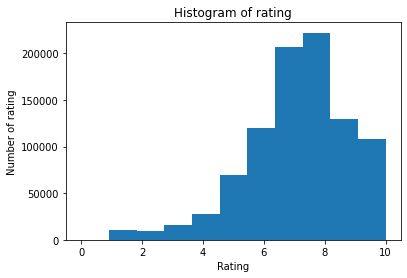

Ratings distribution
+------+------+
|rating| count|
+------+------+
|     0|   281|
|     1| 10814|
|     2|  9223|
|     3| 15487|
|     4| 28193|
|     5| 69747|
|     6|120370|
|     7|206680|
|     8|222146|
|     9|130106|
|    10|108351|
+------+------+



In [22]:
def activity_1_3(df_ratings):
    """ Display rating distribution histogramme
        Counting the number of voters per rating
        Sorting based on ratings

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    """

    # Creation of the histogram
    print("Converting Dataframe to Pandas...")
    plt.hist(
        df_ratings.select("rating").toPandas().squeeze(),
        bins=11)  # [0 to 10] => 11 values
    plt.xlabel('Rating')
    plt.ylabel('Number of rating')
    plt.title('Histogram of rating')
    plt.show()

    print("Ratings distribution")
    df_ratings\
        .groupBy("rating")\
        .count()\
        .orderBy("rating")\
        .show()


activity_1_3(df_ratings)

- 1.4 Finally, we want to obtain a table of frequencies to express the distribution of notes as a percentage.

In [26]:
def activity_1_4(df_ratings):
    """ Added column count which represents the number of voters
        by notes.
        Added a percentage column,
        which is a transformation of the count column into a percentage.
        Selection of rating and percentage columns.
        Sort by rating column.

    Args:
        df_ratings (Dataframe): Rating Dataframe
    """

    df_ratings.groupBy("rating")\
        .count()\
        .withColumn(
            'percentage',
            (col("count")*100)/float(df_ratings.count()))\
        .select("rating", "percentage")\
        .orderBy("rating")\
        .show()


print("Ratings frequencies")
activity_1_4(df_ratings)

Ratings frequencies


+------+-------------------+
|rating|         percentage|
+------+-------------------+
|     0|0.03049713587396543|
|     1| 1.1736513428507551|
|     2| 1.0009789472084811|
|     3| 1.6808154565128208|
|     4| 3.0598069455327663|
|     5|  7.569693009969633|
|     6| 13.063844288787255|
|     7| 22.431131823598488|
|     8|  24.10966813472571|
|     9| 14.120499501843938|
|    10| 11.759413413096187|
+------+-------------------+



### 2. Data selection and enrichment

- 2.1 In order to set up a certain statistical model, we must transform the `rating` note into two modalities: did the user like the film or not?
     Create a new `liked` column in the `ratings` table with the following values: `0` for ratings [0-6] and `1` for ratings [7-10].

In [34]:
def activity_2_1(df_ratings):
    """ Added a liked column.
        Depending on the rating column,
        the liked column takes the value 0 or 1

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    Returns:
        Dataframe: Updated ratings Dataframe
    """

    df_ratings = df_ratings\
        .withColumn(
            'liked',
            when(df_ratings.rating < 7, 0)
            .when(df_ratings.rating >= 7, 1))

    df_ratings.show()

    return df_ratings


print("Updated ratings Dataframe")
df_ratings = activity_2_1(df_ratings)

Updated ratings Dataframe
+-------+--------+------+----------------+-----+
|user_id|movie_id|rating|rating_timestamp|liked|
+-------+--------+------+----------------+-----+
|      1|  114508|     8|      1381006850|    1|
|      2|  499549|     9|      1376753198|    1|
|      2| 1305591|     8|      1376742507|    1|
|      2| 1428538|     1|      1371307089|    0|
|      3|   75314|     1|      1595468524|    0|
|      3|  102926|     9|      1590148016|    1|
|      3|  114369|    10|      1597555347|    1|
|      3|  118715|     8|      1596006798|    1|
|      3|  120737|     8|      1599306720|    1|
|      3|  208092|     5|      1586466072|    0|
|      3|  358273|     9|      1579057827|    1|
|      3|  477348|     6|      1597289003|    0|
|      3|10039344|     5|      1578603053|    0|
|      3| 1051906|     6|      1589924916|    0|
|      3| 1568346|     6|      1597388722|    0|
|      3| 2278388|     8|      1597297732|    1|
|      3| 6199572|     3|      1589482483| 

## Code quality check

In [35]:
!flake8-nb result.ipynb

## Safe Notebook versioning

In [36]:
!jupyter nbconvert result.ipynb --to="python"

[NbConvertApp] Converting notebook result.ipynb to python
[NbConvertApp] Writing 5655 bytes to result.py
